# MovieLens MLN Recommendation via PyTorch

adapted from https://github.com/fastai/fastai

In [1]:
import math
import copy
import pickle
from pathlib import Path
from itertools import zip_longest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim

import time

figure_path = '/home/weiss/git/thesis/doc/figures/'

In [2]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 2021
set_random_seed(RANDOM_STATE)

In [3]:
def read_data(path):
    files = {}
    path = Path(path)
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
        elif filename.suffix == '.data':  # ml-100k
            if filename.stem == 'u':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
                data = pd.read_csv(filename, sep='\t', names=columns, engine='python')
                files['ratings'] = data
        elif filename.suffix == '.item':  # ml-100k
            if filename.stem == 'u':
                columns = ['movieId', 'title', 'genres']
                data = pd.read_csv(filename, sep='|', names=columns, engine='python')
                files['movies'] = data
    return files['ratings'], files['movies']

In [4]:
dataset = 'ml-1m'

# pick one of the available folders
ratings, movies = read_data('/home/weiss/rs_data/'+dataset)

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
movies.head()

,,,,,,,,,,,,,,,,,,,,,movieId,title,genres
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [7]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()

    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)

    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)

    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 943 users, 1682 movies
Dataset shape: (100000, 2)
Target shape: (100000,)


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid), 'test': (X_test, y_test)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid), 'test': len(X_test)}


In [9]:
class RatingsIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [10]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in RatingsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [11]:
class RecommenderNet(nn.Module):
    """
    Creates dense MLN with embedding layers.

    Args:
        n_users:
            Number of unique users in the dataset.

        n_movies:
            Number of unique movies in the dataset.

        n_factors:
            Number of columns in the embeddings matrix.

        embedding_dropout:
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of
            units in hidden layer(s).

        dropouts:
            A single integer or a list of integers defining the dropout
            layers rates applied right after each of hidden layers.

    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02,
                 hidden=10, dropouts=0.2):

        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and
            their activations/dropouts.

            Note that the function captures `hidden` and `dropouts`
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self.relu = nn.ReLU()
        self._init()

    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        #out = self.relu(self.fc(x))  # relu delivers worse rsme
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out

    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """

        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [12]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)


In [13]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax

(1.0, 5.0)

In [80]:
# small net

start = time.time()
net = RecommenderNet(
    n_users=n, n_movies=m,
    n_factors=10, hidden=[10],
    embedding_dropout=0.05, dropouts=[0.3])

In [81]:
lr = 1e-3
wd = 1e-5
bs = 4096
n_epochs = 300
patience = 300
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [82]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    #scheduler.step()
                    loss.backward()
                    optimizer.step()
                    #lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    with open(f'logs/small.txt', 'a') as f:
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
        f.write('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/300] train: 1.3937 - val: 1.1510
loss improvement on epoch: 2
[002/300] train: 1.2975 - val: 1.0737
loss improvement on epoch: 3
[003/300] train: 1.2071 - val: 1.0021
loss improvement on epoch: 4
[004/300] train: 1.1221 - val: 0.9425
loss improvement on epoch: 5
[005/300] train: 1.0612 - val: 0.8986
loss improvement on epoch: 6
[006/300] train: 1.0116 - val: 0.8652
loss improvement on epoch: 7
[007/300] train: 0.9713 - val: 0.8431
loss improvement on epoch: 8
[008/300] train: 0.9444 - val: 0.8274
loss improvement on epoch: 9
[009/300] train: 0.9194 - val: 0.8097
loss improvement on epoch: 10
[010/300] train: 0.9017 - val: 0.7998
loss improvement on epoch: 11
[011/300] train: 0.8865 - val: 0.7914
loss improvement on epoch: 12
[012/300] train: 0.8749 - val: 0.7834
loss improvement on epoch: 13
[013/300] train: 0.8673 - val: 0.7777
loss improvement on epoch: 14
[014/300] train: 0.8604 - val: 0.7769
loss improvement on epoch: 15
[015/300] train: 0.8516 - v

In [83]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [84]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [85]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 0.9570


In [86]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [87]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Small Test RMSE: {final_loss:.4f}')

Small Test RMSE: 0.9637


In [88]:
print(f'Small duration: {round(time.time() - start, 4)}')

Small duration: 8.0946


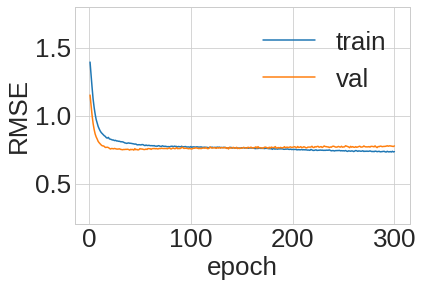

In [89]:
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 26
plt.style.use('seaborn-whitegrid')
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
plt.ylabel('loss')
plt.ylim([0.2, 1.8])

plt.savefig(figure_path + '/' + dataset +'-small-loss.png', dpi=300, bbox_inches='tight')


In [90]:
with open('best.weights.small', 'wb') as file:
    pickle.dump(best_weights, file)

In [91]:
# medium net

start = time.time()
net = RecommenderNet(
    n_users=n, n_movies=m,
    n_factors=20, hidden=[10 ,10],
    embedding_dropout=0.05, dropouts=[0.3, 0.3])

In [92]:
lr = 1e-3
wd = 1e-5
bs = 4096
n_epochs = 300
patience = 300
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [93]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    #scheduler.step()
                    loss.backward()
                    optimizer.step()
                    #lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    with open(f'logs/medium.txt', 'a') as f:
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
        f.write('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/300] train: 1.4179 - val: 1.1567
loss improvement on epoch: 2
[002/300] train: 1.2987 - val: 1.0687
loss improvement on epoch: 3
[003/300] train: 1.2083 - val: 1.0054
loss improvement on epoch: 4
[004/300] train: 1.1396 - val: 0.9665
loss improvement on epoch: 5
[005/300] train: 1.0842 - val: 0.9235
loss improvement on epoch: 6
[006/300] train: 1.0430 - val: 0.8970
loss improvement on epoch: 7
[007/300] train: 0.9950 - val: 0.8625
loss improvement on epoch: 8
[008/300] train: 0.9626 - val: 0.8402
loss improvement on epoch: 9
[009/300] train: 0.9338 - val: 0.8280
loss improvement on epoch: 10
[010/300] train: 0.9121 - val: 0.8174
loss improvement on epoch: 11
[011/300] train: 0.8990 - val: 0.8095
loss improvement on epoch: 12
[012/300] train: 0.8853 - val: 0.8067
loss improvement on epoch: 13
[013/300] train: 0.8799 - val: 0.7957
loss improvement on epoch: 14
[014/300] train: 0.8702 - val: 0.7948
loss improvement on epoch: 15
[015/300] train: 0.8615 - v

In [94]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [95]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [96]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 0.9784


In [97]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [98]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Medium test RMSE: {final_loss:.4f}')

Medium test RMSE: 0.9895


In [99]:
print(f'Medium duration: {round(time.time() - start, 4)}')

Medium duration: 9.702


In [100]:
with open('best.weights.medium', 'wb') as file:
    pickle.dump(best_weights, file)

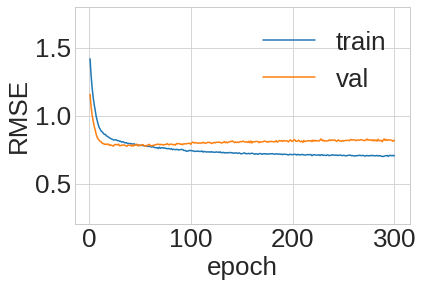

In [101]:
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 26
plt.style.use('seaborn-whitegrid')
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
plt.ylabel('loss')
plt.ylim([0.2, 1.8])

plt.savefig(figure_path + '/' + dataset +'-medium-loss.png', dpi=300, bbox_inches='tight')

In [102]:
# large net

start = time.time()
net = RecommenderNet(
    n_users=n, n_movies=m,
    n_factors=50, hidden=[100, 100, 100],
    embedding_dropout=0.05, dropouts=[0.3, 0.3, 0.3])

In [103]:
lr = 1e-3
wd = 1e-5
bs = 4096
n_epochs = 300
patience = 300
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [104]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    #scheduler.step()
                    loss.backward()
                    optimizer.step()
                    #lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    with open(f'logs/large.txt', 'a') as f:
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
        f.write('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/300] train: 1.2516 - val: 1.0223
loss improvement on epoch: 2
[002/300] train: 1.1229 - val: 0.9022
loss improvement on epoch: 3
[003/300] train: 0.9791 - val: 0.8222
loss improvement on epoch: 4
[004/300] train: 0.9104 - val: 0.7966
loss improvement on epoch: 5
[005/300] train: 0.8680 - val: 0.7694
loss improvement on epoch: 6
[006/300] train: 0.8407 - val: 0.7554
loss improvement on epoch: 7
[007/300] train: 0.8187 - val: 0.7469
loss improvement on epoch: 8
[008/300] train: 0.8008 - val: 0.7404
loss improvement on epoch: 9
[009/300] train: 0.7925 - val: 0.7381
[010/300] train: 0.7822 - val: 0.7395
[011/300] train: 0.7719 - val: 0.7388
[012/300] train: 0.7649 - val: 0.7411
[013/300] train: 0.7562 - val: 0.7394
[014/300] train: 0.7439 - val: 0.7459
[015/300] train: 0.7362 - val: 0.7492
[016/300] train: 0.7282 - val: 0.7527
[017/300] train: 0.7137 - val: 0.7517
[018/300] train: 0.7016 - val: 0.7658
[019/300] train: 0.6850 - val: 0.7695
[020/300] train: 

In [105]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [106]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [107]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 0.9499


In [108]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [109]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Large test RMSE: {final_loss:.4f}')

Large test RMSE: 0.9527


In [110]:
print(f'Large duration: {round(time.time() - start, 4)}')


Large duration: 10.5609


In [111]:
with open('best.weights.big', 'wb') as file:
    pickle.dump(best_weights, file)

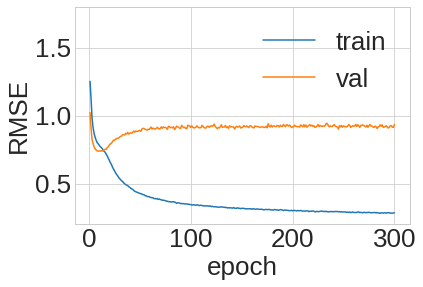

In [112]:
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 26
plt.style.use('seaborn-whitegrid')
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
plt.ylabel('loss')
plt.ylim([0.2, 1.8])

plt.savefig(figure_path + '/' + dataset +'-large-loss.png', dpi=300, bbox_inches='tight')